In [1]:
import os
# Suppress INFO & WARNING logs from TensorFlow.
# This project's logs often mention GPU drivers or Google Cloud authentication,
# even if you are only running on CPU. They are safe to ignore in this project.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

# Data Handling

## Task 1: Import the Libraries

In [2]:
import tensorflow as tf
import tensorflow_datasets  as tfds
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image

## Task 2: Load the Dataset

In [3]:
data = tfds.ImageFolder('/usercode/cell_images/')
data = data.as_dataset(split="train")

In [4]:
malaria_builder = tfds.builder("malaria")

info = malaria_builder.info

info.as_proto

name: "malaria"
description: "The Malaria dataset contains a total of 27,558 cell images with equal instances\nof parasitized and uninfected cells from the thin blood smear slide images of\nsegmented cells."
version: "1.0.0"
citation: "@article{rajaraman2018pre,\n  title={Pre-trained convolutional neural networks as feature extractors toward\n  improved malaria parasite detection in thin blood smear images},\n  author={Rajaraman, Sivaramakrishnan and Antani, Sameer K and Poostchi, Mahdieh\n  and Silamut, Kamolrat and Hossain, Md A and Maude, Richard J and Jaeger,\n  Stefan and Thoma, George R},\n  journal={PeerJ},\n  volume={6},\n  pages={e4568},\n  year={2018},\n  publisher={PeerJ Inc.}\n}"
size_in_bytes: 353452851
location {
  urls: "https://lhncbc.nlm.nih.gov/publication/pub9932"
}
schema {
  feature {
    name: "image"
    shape {
      dim {
        size: -1
      }
      dim {
        size: -1
      }
      dim {
        size: 3
      }
    }
    type: INT
  }
  feature {
    nam

In [5]:
info.splits

{'train': <SplitInfo num_examples=27558, num_shards=4>}

In [6]:
info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
})

## Task 3: Visualize Images

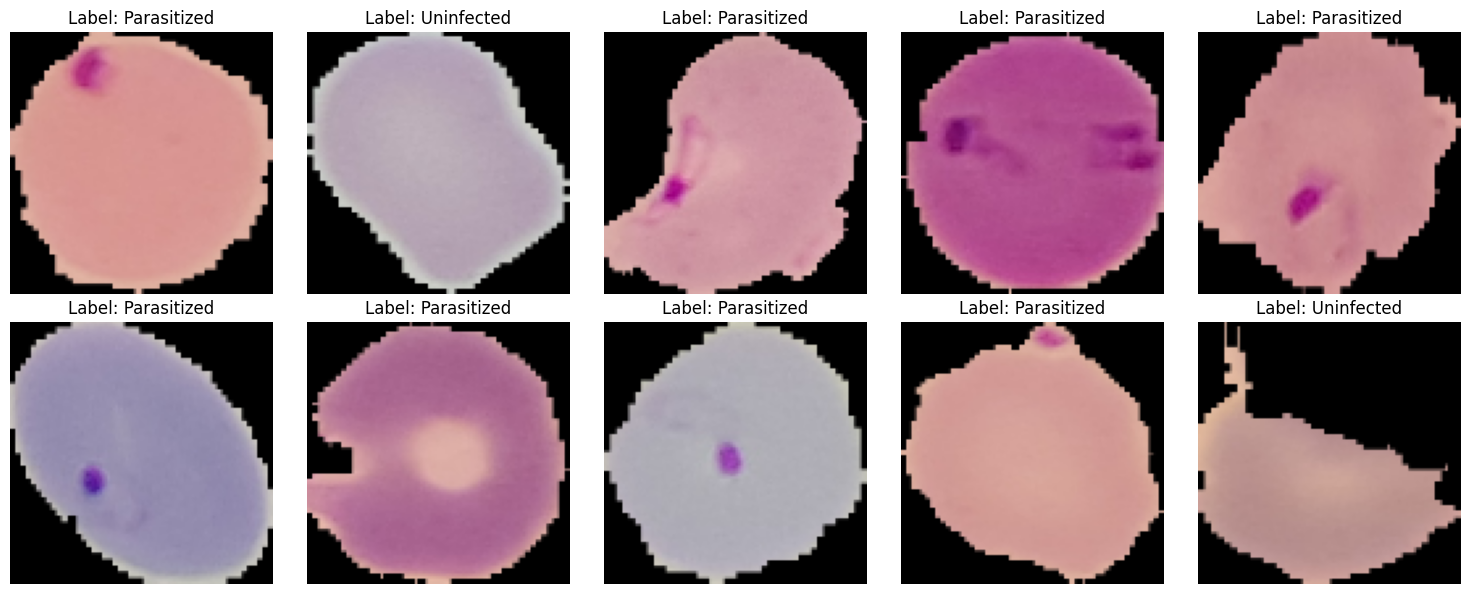

In [7]:
# Define the figure (2 rows with 5 images each) and axis objects
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
# Flatten the axes array
axs = axs.ravel()

# Load first 10 examples
for i, example in enumerate(data.take(10)):
    image = example["image"]
    label = example["label"]

    # Resize image for consistent display
    image = tf.image.resize(image, [100, 100])

    # Plot image and set title to the corresponding label
    axs[i].imshow(image.numpy().astype("uint8"))
    axs[i].title.set_text(f'Label: {"Parasitized" if label.numpy()==0 else "Uninfected"}')
    # Hide axes for visual appeal
    axs[i].axis('off')

plt.tight_layout()
plt.show()

## Task 4: Preprocess the Images

In [8]:
image = [example["image"] for example in data.take(1)][0]

In [9]:
image_resized = tf.image.resize(image,(64,64)).numpy()

In [10]:
image_gray = cv2.cvtColor(image_resized,cv2.COLOR_BGR2GRAY)

In [11]:
image_normalized = image_gray/255.0

In [12]:
image_blur = cv2.GaussianBlur(image_normalized,(5,5),0)

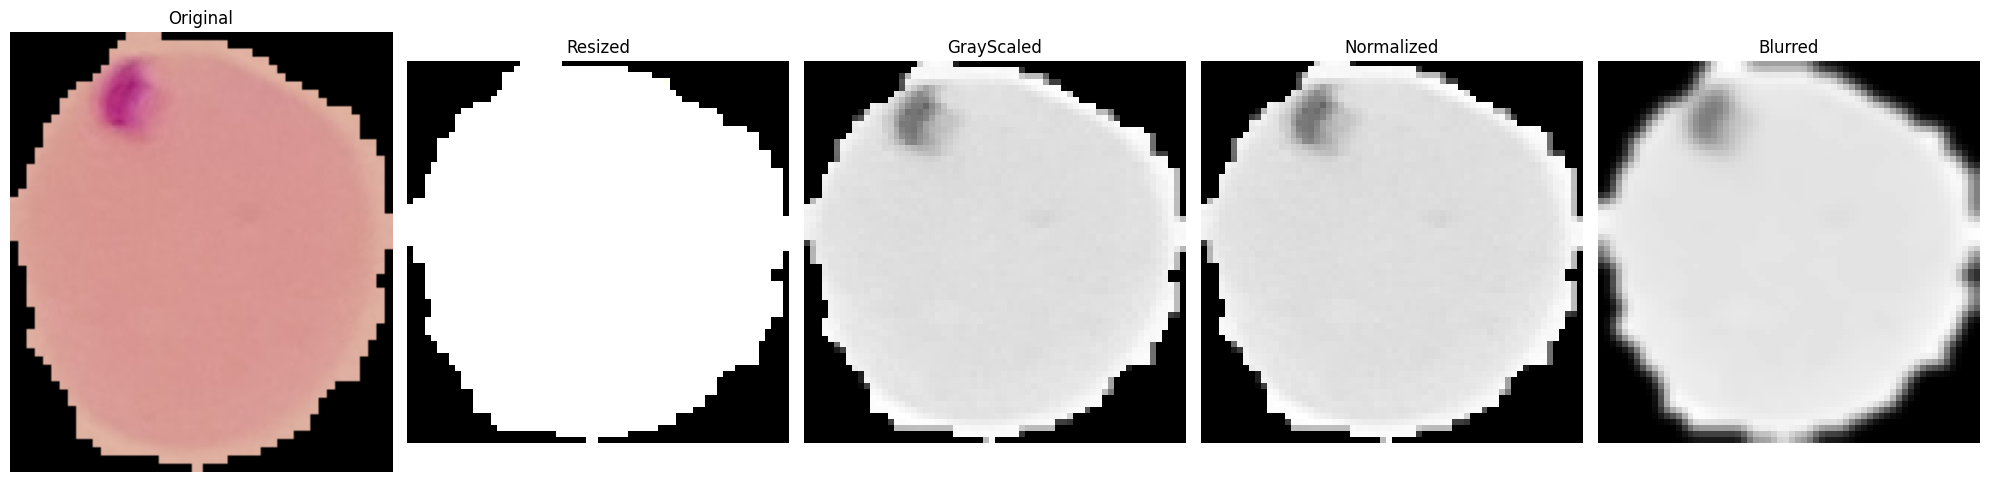

In [13]:
fig,axs = plt.subplots(1,5,figsize=(20,20))

titles = ["Original","Resized","GrayScaled","Normalized","Blurred"]

images = [image,image_resized,image_gray,image_normalized,image_blur]

for i,img in enumerate(images):
    axs[i].imshow(img,cmap='gray')
    axs[i].set_title(titles[i])
    axs[i].axis('off')


plt.tight_layout()
plt.show()

## Task 5: Split the Data

In [14]:
data = data.shuffle(buffer_size=10000)

In [15]:
data = data.take(len(data)//10)

In [16]:
TRAIN_SET_SIZE = 0.7
VAL_SET_SIZE = 0.15
TEST_SET_SIZE = 0.15

dataset_size = len(data)

train_size = int(TRAIN_SET_SIZE * dataset_size)
val_size = int(VAL_SET_SIZE * dataset_size)
test_size = int(TEST_SET_SIZE * dataset_size)

In [17]:
train_dataset = data.take(train_size)
val_test_dataset = data.skip(train_size)

val_dataset = val_test_dataset.skip(val_size)
test_dataset = val_test_dataset.take(test_size)

In [18]:
def print_class_counts(dataset,dataset_name):
    count_positive=0
    count_negative=0
    #positive means uninfected and negative means parasitized
    for sample in dataset:

        if sample["label"] == 1:
            count_positive+=1
        else:
            count_negative +=1
    print(f'{dataset_name}:')
    print(f'Positive samples: {count_positive}, Proportion: {count_positive / (count_positive + count_negative):.2f}')
    print(f'Negative samples: {count_negative}, Proportion: {count_negative / (count_positive + count_negative):.2f}')
    print()

print_class_counts(train_dataset, 'Train Dataset')
print_class_counts(val_dataset, 'Validation Dataset')
print_class_counts(test_dataset, 'Test Dataset')

Train Dataset:
Positive samples: 951, Proportion: 0.49
Negative samples: 977, Proportion: 0.51

Validation Dataset:
Positive samples: 223, Proportion: 0.54
Negative samples: 191, Proportion: 0.46

Test Dataset:
Positive samples: 237, Proportion: 0.57
Negative samples: 176, Proportion: 0.43



## Task 6: Augment the Images

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_gen = ImageDataGenerator(
    rotation_range=90,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)

In [20]:
sample_image = next(iter(data))['image']
sample_image = tf.image.resize(sample_image,[64,64])

sample_image = np.expand_dims(sample_image,axis=0)

aug_iter = data_gen.flow(sample_image)

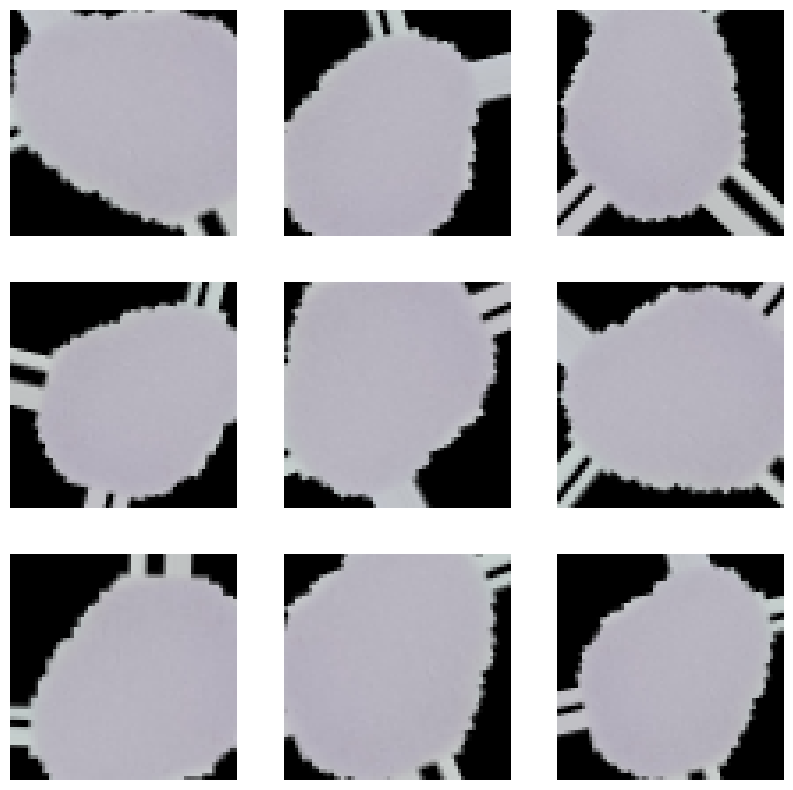

In [21]:
fig,axs = plt.subplots(3,3,figsize=(10,10))

for i,ax in enumerate(axs.flat):
    augmented_image = next(aug_iter)[0].astype('uint8')
    ax.imshow(augmented_image)
    ax.axis('off')

plt.show()

In [22]:
#Augment training set
def augment_train_images(sample):
    image = sample["image"]
    label = sample["label"]

    image = tf.image.resize(image,IMG_SIZE) #resize
    image = tf.image.random_flip_left_right(image) #random horizontal flip
    image = tf.image.random_flip_up_down(image) #random vertical flip
    image = tf.image.random_brightness(image,max_delta=0.1) #random brightness
    image = tf.image.random_contrast(image,lower=0.1,upper=0.2) #random contrast
    image = tf.image.per_image_standardization(image) #normalize each image

    return image,label

#Only resize and standardize validation and test set
def augment_val_test_images(sample):
    image = sample["image"]
    label = sample["label"]

    image = tf.image.resize(image,IMG_SIZE)
    image = tf.image.per_image_standardization(image)

    return image, label




In [23]:
BATCH_SIZE = 32
IMG_SIZE = (64,64)

augmented_train_dataset = train_dataset.map(augment_train_images).batch(BATCH_SIZE)
resized_val_dataset = val_dataset.map(augment_val_test_images).batch(BATCH_SIZE)
resized_test_dataset = test_dataset.map(augment_val_test_images).batch(BATCH_SIZE)

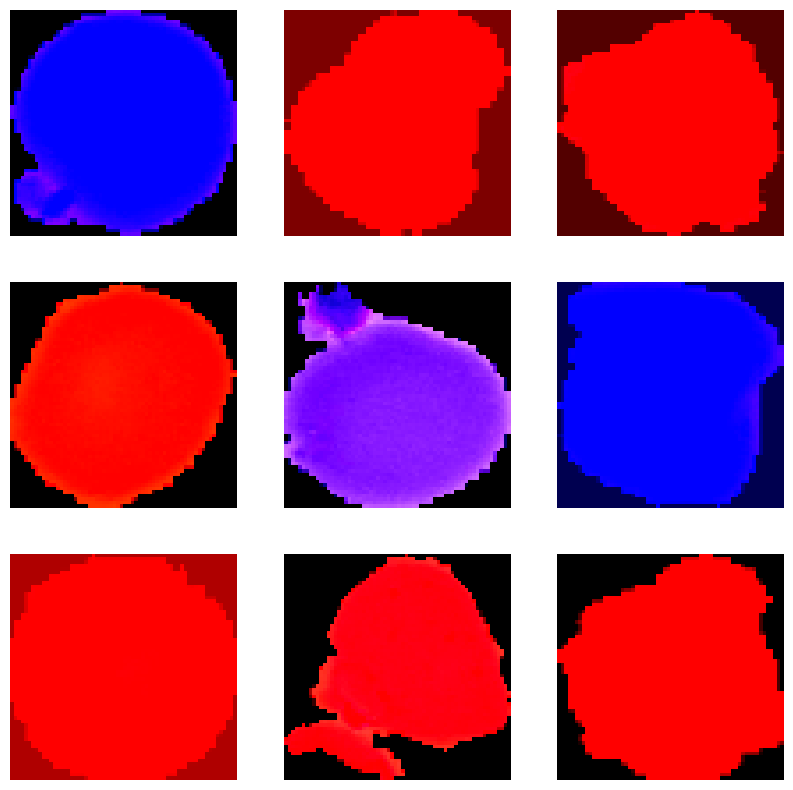

In [24]:
fig, axs = plt.subplots(3,3,figsize=(10,10))

for i, (image_batch, label_batch) in enumerate(augmented_train_dataset.take(9)):

    image = image_batch[0]

    axs[i//3, i%3].imshow(image)
    axs[i//3,i%3].axis('off')

plt.show()

# Building an Image Classifier with TensorFlow

## Task 7: Set Up a Neural Network

In [25]:
from tensorflow.keras import layers

In [26]:
train_set = augmented_train_dataset
val_set = resized_val_dataset
test_set = resized_test_dataset

In [27]:
for image_batch,label_batch in train_set.take(1):
    input_shape = image_batch[0].shape
    num_classes = len(tf.unique(label_batch).y)

print(f"Image shape: {input_shape}")
print(f"Number of classes: {num_classes}")


Image shape: (64, 64, 3)
Number of classes: 2


## Task 8: Define the Model Architecture

In [28]:
cnn_model = tf.keras.Sequential([
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(1,activation='sigmoid')
])



In [29]:
cnn_model.build(input_shape=(None,64,64,3))
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 9216)              0

In [30]:
'''Basic CNNs have depth limits due to vanishing/exploding gradient issues. 
ResNets address this with skip connections facilitating gradient backpropagation to 
earlier layers. This leads to a major advantage, which is that ResNets can be much deeper 
than traditional CNNs.
ResNet blocks use convolutional and activation layers, and then add the stack’s output to 
the previous stack’s output. In addition, a GlobalAveragePooling2D layer is used before 
the final Dense layers to reduce spatial dimensions, parameter count, 
and potential overfitting.'''

#input layer
inputs = tf.keras.Input(shape=input_shape)

#First block
x = layers.Conv2D(32,3,activation='relu')(inputs)
x = layers.Conv2D(64,3,activation='relu')(x)
block_1_output = layers.MaxPooling2D(3)(x)

#Second block with residual connection
x = layers.Conv2D(64,3,activation='relu',padding='same')(block_1_output)
x = layers.Conv2D(64,3,activation='relu',padding='same')(x)
block_2_output = layers.add([x,block_1_output])

#Third block with residual connection
x = layers.Conv2D(64,3,activation='relu',padding='same')(block_2_output)
x = layers.Conv2D(64,3,activation='relu',padding='same')(x)
block_3_output = layers.add([x,block_2_output])

#Final layer including the output layer
x = layers.Conv2D(64,3,activation='relu')(block_3_output)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256,activation='relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(1,activation='sigmoid')(x)

resnet_model = tf.keras.Model(inputs,outputs)


In [31]:
resnet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 62, 62, 32)           896       ['input_1[0][0]']             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 60, 60, 64)           18496     ['conv2d_3[0][0]']            
                                                                                                  
 max_pooling2d_2 (MaxPoolin  (None, 20, 20, 64)           0         ['conv2d_4[0][0]']            
 g2D)                                                                                         

## Task 9: Prepare the Model for Training

In [32]:
'''Common binary classification loss functions include:

Binary cross-entropy: It’s suitable for exclusive class data such as parasitized vs. uninfected.
Squared loss: It measures the squared difference between predictions and actual results.
For this task, you’ll use binary cross-entropy because it’s apt for binary classification and it excels with probabilistic predictions.

Next, optimizers adjust model attributes, such as weights, to reduce loss. Common optimizers are:

Stochastic gradient descent (SGD): It updates the model’s weights using the gradient of the loss function. The learning rate defines the size of steps taken.
Adagrad: It adapts the learning rate to the parameters, performing smaller updates for frequent and larger updates for infrequent parameters.
RMSprop: It’s an adaptation of Adagrad that uses a moving average of squared gradients instead, giving newer updates more weight than older ones.
Adam: It combines the perks of Adagrad and RMSprop by applying adaptive learning rates and separate momentums for each weight in the network.
Evaluation metrics are there to gauge model performance. Common metrics to use are:

Accuracy: It’s the ratio of correct predictions to total observations.
Precision: It’s the ratio of correct positive predictions to total positive predictions.
Recall: It’s the ratio of correct positive predictions to all actual positives.
F1 Score: It’s the harmonic mean of precision and recall.
AUC ROC: It compares the true positive rate against the false positive rate.
'''

loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0)


In [33]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
legacy_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)

In [34]:
metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc')
]

In [35]:
cnn_model.compile(optimizer=optimizer,loss=loss_fn,metrics=metrics)
resnet_model.compile(optimizer=legacy_optimizer,loss=loss_fn,metrics=metrics)

## Task 10: Train and Monitor the Net

In [36]:
'''Common callbacks are:
EarlyStopping: It stops training when the model’s performance ceases to improve.
ReduceLROnPlateau: It decreases the learning rate when a metric stops improving.
LearningRateScheduler: It alters the learning rate dynamically during training.
ModelCheckpoint: It saves the model after each epoch, which is useful for resuming or choosing the best model.'''


EPOCHS = 2
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3)

def scheduler(epoch,lr):
    if epoch <2:
        return lr* tf.math.exp(-0.1)

lr_schedular = tf.keras.callbacks.LearningRateScheduler(scheduler)


In [37]:
'''TensorBoard provides visual insights during training, such as:

Metrics visualization (loss, accuracy)
Model graph visualization
Histograms of model parameters'''
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

In [38]:
%load_ext tensorboard
%tensorboard --logdir logs

In [39]:
cnn_history = cnn_model.fit(
    train_set,
    validation_data=val_set,
    epochs=EPOCHS,
    callbacks = [early_stopping_callback,lr_schedular,tensorboard_callback]
)

Epoch 1/2
61/61 [==============================] - 32s 418ms/step - loss: 0.6638 - accuracy: 0.6017 - precision: 0.6108 - recall: 0.5717 - auc: 0.6459 - val_loss: 0.6481 - val_accuracy: 0.6159 - val_precision: 0.6462 - val_recall: 0.6199 - val_auc: 0.6558 - lr: 9.0484e-04
Epoch 2/2
61/61 [==============================] - 27s 282ms/step - loss: 0.6174 - accuracy: 0.6623 - precision: 0.6845 - recall: 0.6412 - auc: 0.7192 - val_loss: 0.9382 - val_accuracy: 0.4734 - val_precision: 0.4658 - val_recall: 0.9634 - val_auc: 0.6437 - lr: 8.1873e-04


In [40]:
resnet_history = resnet_model.fit(
    train_set,
    validation_data=val_set,
    epochs=EPOCHS,
    callbacks=[early_stopping_callback,lr_schedular,tensorboard_callback]
)

Epoch 1/2
61/61 [==============================] - 71s 1s/step - loss: 0.6741 - accuracy: 0.6037 - precision: 0.5676 - recall: 0.6772 - auc: 0.5840 - val_loss: 0.7373 - val_accuracy: 0.5169 - val_precision: 0.5169 - val_recall: 1.0000 - val_auc: 0.5309 - lr: 9.0484e-04
Epoch 2/2
61/61 [==============================] - 53s 750ms/step - loss: 0.6605 - accuracy: 0.6120 - precision: 0.6134 - recall: 0.6938 - auc: 0.6436 - val_loss: 0.7688 - val_accuracy: 0.4783 - val_precision: 0.4783 - val_recall: 1.0000 - val_auc: 0.5765 - lr: 8.1873e-04


## Task 11: Evaluate the Performance

In [41]:
'''receiver operating characteristic (ROC) curve, which is a plot that 
illustrates the true positive rate against the false positive rate at various threshold settings. 
Furthermore, you should also look into the area under the curve (AUC) of the ROC curve, 
which in turn is used as a measure of the performance of the classification model.'''

test_loss, test_acc, test_precision, test_recall, test_auc = resnet_model.evaluate(test_set)
print("test loss, test accuracy, test precision, test recall, test auc: ", test_loss, test_acc, test_precision, test_recall, test_auc)


13/13 [==============================] - 13s 333ms/step - loss: 0.7675 - accuracy: 0.4818 - precision: 0.4818 - recall: 1.0000 - auc: 0.5316
test loss, test accuracy, test precision, test recall, test auc:  0.7675250172615051 0.48184019327163696 0.48184019327163696 1.0 0.5316418409347534


13/13 [==============================] - 8s 170ms/step


<Axes: >

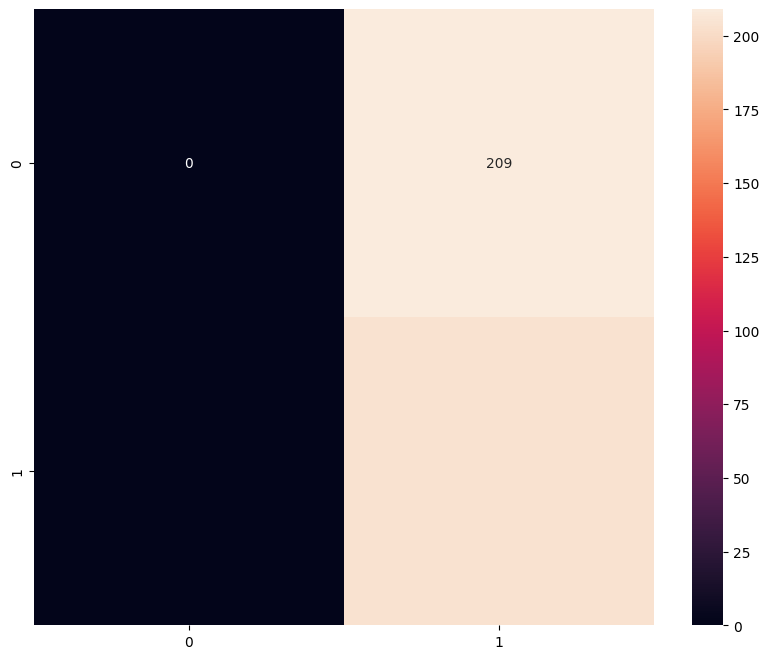

In [42]:
#confusion matrix

import seaborn as sns

y_pred = resnet_model.predict(test_set)
y_pred_classes = np.concatenate(y_pred >= 0.5).astype(int)

y_true = np.concatenate([labels for img, labels in test_set])

confusion_matrix = tf.math.confusion_matrix(y_true,y_pred_classes)

plt.figure(figsize=(10,8))
sns.heatmap(confusion_matrix,annot=True,fmt="d")

In [43]:
from sklearn.metrics import classification_report
print(classification_report(y_true,y_pred_classes))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       209
           1       0.49      1.00      0.66       204

    accuracy                           0.49       413
   macro avg       0.25      0.50      0.33       413
weighted avg       0.24      0.49      0.33       413



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


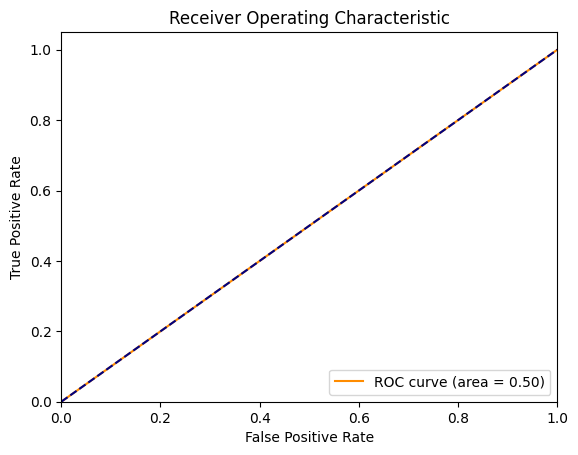

In [44]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_true, y_pred_classes)
roc_auc = auc(fpr, tpr)

plt.figure()

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

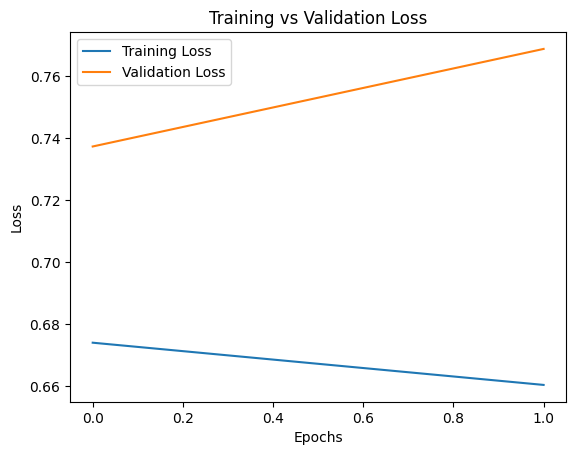

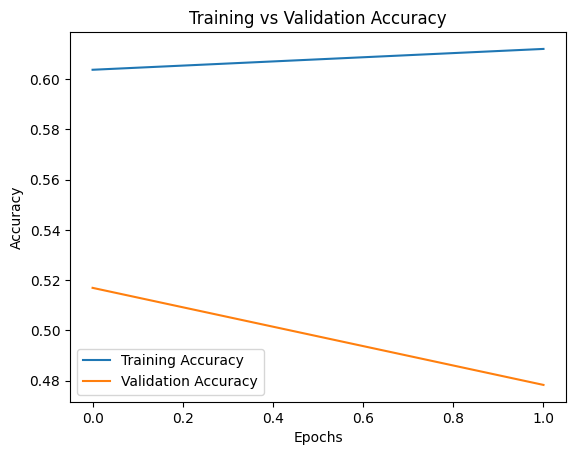

In [45]:
# Retrieve history of loss and accuracy during training
hist = resnet_history.history

# Plot training vs. validation loss
plt.figure()
plt.plot(hist['loss'], label='Training Loss')
plt.plot(hist['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

# Plot training vs. validation accuracy
plt.figure()
plt.plot(hist['accuracy'], label='Training Accuracy')
plt.plot(hist['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

In [46]:
# Compare test set performance to training and validation set
print(f"Training Accuracy: {np.round(np.max(hist['accuracy']), 3)}")
print(f"Validation Accuracy: {np.round(np.max(hist['val_accuracy']), 3)}")
print(f"Test Accuracy: {np.round(test_acc, 3)}")

print()

print(f"Training Loss: {np.round(np.min(hist['loss']), 3)}")
print(f"Validation Loss: {np.round(np.min(hist['val_accuracy']), 3)}")
print(f"Test Loss: {np.round(test_loss, 3)}")

print()

print(f"Training Precision: {np.round(np.min(hist['precision']), 3)}")
print(f"Validation Precision: {np.round(np.min(hist['val_precision']), 3)}")
print(f"Test Precision: {np.round(test_precision, 3)}")

print()

print(f"Training Recall: {np.round(np.min(hist['recall']), 3)}")
print(f"Validation Recall: {np.round(np.min(hist['val_recall']), 3)}")
print(f"Test Recall: {np.round(test_recall, 3)}")

print()

print(f"Training AUC: {np.round(np.min(hist['auc']), 3)}")
print(f"Validation AUC: {np.round(np.min(hist['val_auc']), 3)}")
print(f"Test AUC: {np.round(test_auc, 3)}")

Training Accuracy: 0.612
Validation Accuracy: 0.517
Test Accuracy: 0.482

Training Loss: 0.66
Validation Loss: 0.478
Test Loss: 0.768

Training Precision: 0.568
Validation Precision: 0.478
Test Precision: 0.482

Training Recall: 0.677
Validation Recall: 1.0
Test Recall: 1.0

Training AUC: 0.584
Validation AUC: 0.531
Test AUC: 0.532


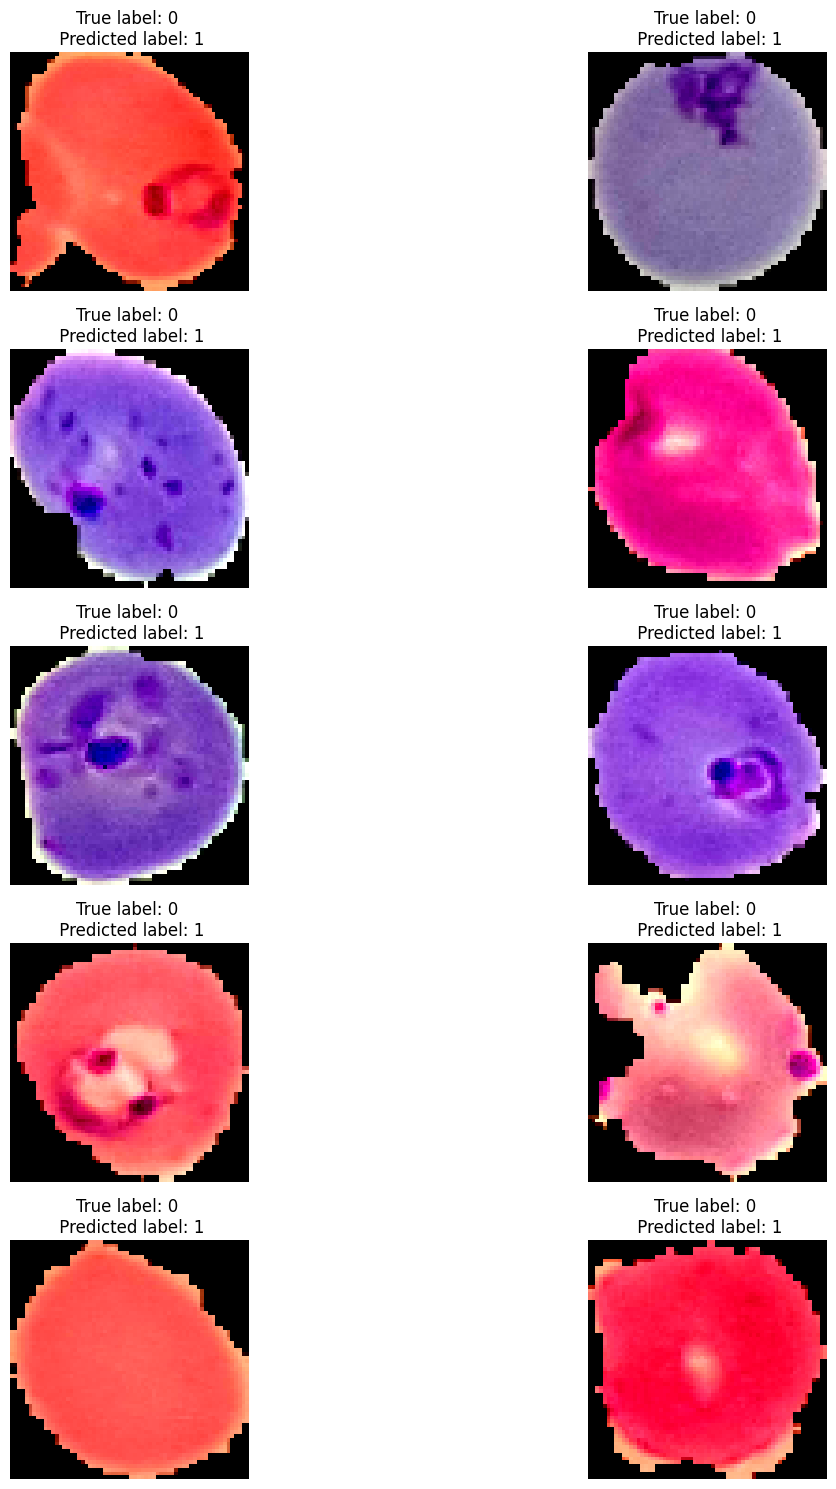

In [47]:
# Get misclassified indices
misclassified_idx = np.where(y_pred_classes != y_true)[0]

# Sample misclassified images
sample_idx = np.random.choice(misclassified_idx, size=10, replace=False)

test_list = []
for batch_img, batch_labels in test_set.as_numpy_iterator():
    for img, label in zip(batch_img, batch_labels):
        test_list.append((img, label))

# Plot misclassified samples
plt.figure(figsize=(15, 15))

for i, idx in enumerate(sample_idx):
    plt.subplot(5, 2, i+1)

    img, _ = test_list[idx]
    label = y_true[idx]
    
    plt.imshow(np.squeeze(img))
    plt.title(f"True label: {label} \n Predicted label: {y_pred_classes[idx]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Building an Image Classifier with PyTorch

## Task 12: Set Up a Neural Network

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [49]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device: ', device)

Using device:  cpu


In [50]:
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated: ',round(torch.data.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:  ',round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

In [51]:
#Transform tensorflow dataset to Pytorch compatible dataset

class NumpyDataset(Dataset):
    def __init__(self,data,labels):
        self.data = data
        self.labels = labels
    
    def __getitem__(self, index):
        return self.data[index], self.labels[index]
    
    def __len__(self):
        return len(self.data)

In [52]:
#Convert Tensorflow dataset to numpy arrays

numpy_train_data = np.concatenate([data for data, _ in train_set.as_numpy_iterator()])
numpy_train_labels = np.concatenate([labels for _,labels in train_set.as_numpy_iterator()])

numpy_val_data = np.concatenate([data for data, _ in val_set.as_numpy_iterator()])
numpy_val_labels = np.concatenate([labels for _,labels in val_set.as_numpy_iterator()])

numpy_test_data = np.concatenate([data for data, _ in test_set.as_numpy_iterator()])
numpy_test_labels = np.concatenate([labels for _,labels in test_set.as_numpy_iterator()])


In [53]:
#Create PyTorch dataloader from PyTorch dataset

train_dataloader = DataLoader(NumpyDataset(numpy_train_data,numpy_train_labels), batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(NumpyDataset(numpy_val_data,numpy_train_labels), batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(NumpyDataset(numpy_test_data,numpy_train_labels), batch_size=BATCH_SIZE, shuffle=True)

## Task 13: Define the Model Architecture

In [54]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        # Apply convolution -> ReLU -> pooling operations
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        # Flatten the tensor
        x = x.reshape(-1, 64 * 16 * 16)
        # Apply fully connected layer -> ReLU
        x = F.relu(self.fc1(x))
        # Final output layer
        x = self.fc2(x)
        return torch.sigmoid(x)

# Initialize the model
simple_model = SimpleCNN()
# Move the model to the device
simple_model = simple_model.to(device)

In [55]:
from torchsummary import summary
summary(simple_model,(3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
         MaxPool2d-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Linear-5                  [-1, 512]       8,389,120
            Linear-6                    [-1, 1]             513
Total params: 8,409,025
Trainable params: 8,409,025
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 1.88
Params size (MB): 32.08
Estimated Total Size (MB): 34.00
----------------------------------------------------------------


In [56]:
#ResNet Model

class ResidualBlock(nn.Module):
    def __init__(self,in_channels,out_channels,stride=1):
        super(ResidualBlock,self).__init__()
        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=stride,padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size=3,stride=1,padding=1,bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self,x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out
    
class ResNet(nn.Module):
    def __init__(self,block,num_blocks,num_classes=1):
        super(ResNet,self).__init__()
        self.in_channels=64
        self.conv1 = nn.Conv2d(3,64,kernel_size=3,stride=1,padding=1,bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block,64,num_blocks[0],stride=1)
        self.layer2 = self._make_layer(block,128,num_blocks[1],stride=2)
        self.layer3 = self._make_layer(block,256,num_blocks[2],stride=2)
        self.linear = nn.Linear(256,num_classes)

    def _make_layer(self,block,out_channels,num_blocks,stride):
        strides = [stride] + [1] * (num_blocks -1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels,out_channels,stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self,x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out,out.size()[3])
        out = out.view(out.size(0),-1)
        out = self.linear(out)
        return torch.sigmoid(out)

#Initialize the model
resnet_model = ResNet(ResidualBlock,[2,2,2])
#Move the model to the device
resnet_model = resnet_model.to(device)
            

In [57]:
summary(resnet_model, (3,64,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
     ResidualBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
    ResidualBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1, 128,

## Task 14: Prepare the Model for Training

In [58]:
learning_rate = 0.001
loss_fn = torch.nn.BCELoss()

In [59]:
simple_optimizer = torch.optim.Adam(simple_model.parameters(), lr=learning_rate)
resnet_optimizer = torch.optim.Adam(resnet_model.parameters(),lr=learning_rate)

In [60]:
simple_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(simple_optimizer,'min')
resnet_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(resnet_optimizer,'min')

## Task 15: Train and Monitor the Network

In [61]:
def save_checkpoint(epoch,model,optimizer,loss,save_path):
    #Save model checkpoint if conditions are met
    model.eval()
    torch.save({
        'epoch':epoch,
        'model_state_dict':model.state_dict(),
        'optimizer_state_dict':optimizer.state_dict(),
        'loss':loss,
    }, save_path)

In [62]:
EPOCHS = 2

dataloaders = {"train": train_dataloader, "val": val_dataloader}

dataset_sizes = {"train": sum(len(i[0]) for i in train_dataloader),
                 "val": sum(len(i[0]) for i in val_dataloader)}

In [63]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs}')

        for phase in ['train','val']:
            model.train() if phase == 'train' else model.eval()

            running_loss =0.0
            running_corrects =0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                #Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.permute(0,3,1,2))
                    _, preds = torch.max(outputs,1)
                    loss = criterion(outputs.reshape(-1), labels.float())

                    if phase == "train":
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step(loss)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        save_checkpoint(epoch,model,optimizer,loss,f'./model_checkpoint_epoch_{epoch}.pth')

                


In [64]:
train_model(simple_model,loss_fn,simple_optimizer,simple_scheduler,EPOCHS)


Epoch 0/2
train Loss: 0.7563 Acc: 0.5062
val Loss: 0.6931 Acc: 0.5024
Epoch 1/2
train Loss: 0.6928 Acc: 0.5062
val Loss: 0.6935 Acc: 0.5024


In [65]:
train_model(resnet_model,loss_fn,resnet_optimizer,resnet_scheduler,EPOCHS)


Epoch 0/2
train Loss: 0.7604 Acc: 0.5062
val Loss: 0.6949 Acc: 0.5024
Epoch 1/2
train Loss: 0.6992 Acc: 0.5062
val Loss: 0.7021 Acc: 0.5024


## Task 16: Evaluate the Performance

In [66]:
# Load the best model weights
resnet_model.load_state_dict(torch.load(f'./model_checkpoint_epoch_{EPOCHS-1}.pth')["model_state_dict"])

# Switch the model to evaluation mode
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [67]:
# Initialize the test loss and correct predictions counter
test_loss = 0.0
correct = 0

# Get all predictions in a list
all_preds = []
all_targets = []

# Don’t compute gradients for performance
with torch.no_grad():
    # Loop over test data
    for data, target in test_dataloader:
        # Move data and target to the correct device
        data, target = data.to(device), target.to(device)
        # Forward pass
        outputs = resnet_model(data.permute(0, 3, 1, 2))
        # Compute the loss
        _, preds = torch.max(outputs, 1)
        loss = torch.nn.BCELoss()(outputs.reshape(-1), target.float())
        # Update the test loss 
        test_loss += loss.item()*data.size(0)
        # Compare predictions to true label
        correct += torch.sum(preds == target.data)

        # Save all predictions and target values
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Calculate average loss
test_loss = test_loss/len(test_dataloader.dataset)

print('Test Loss: {:.6f}\n'.format(test_loss))

# Calculate accuracy
accuracy = correct.double() / len(test_dataloader.dataset)

print('\nTest Accuracy: {:.6f} ({}/{})'.format(accuracy, correct, len(test_dataloader.dataset)))

Test Loss: 0.703229


Test Accuracy: 0.501211 (207/413)


<Axes: >

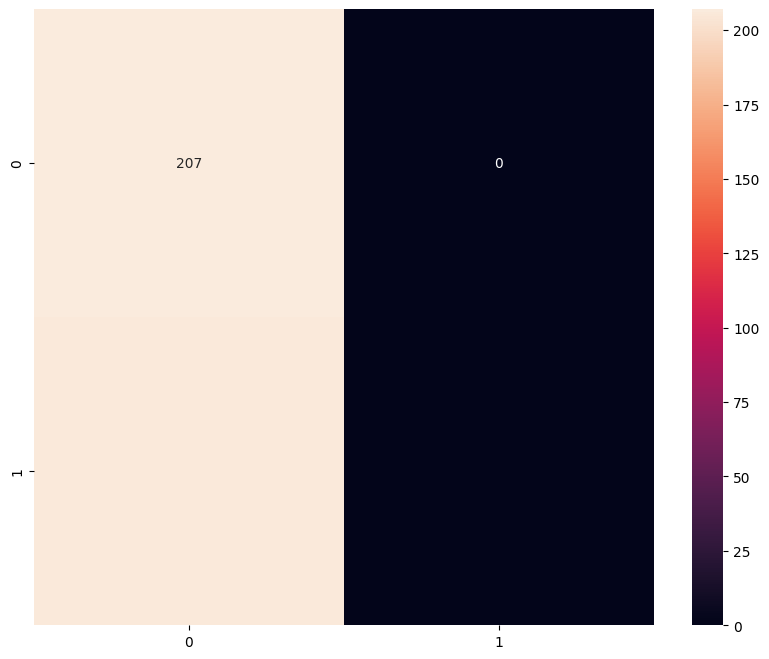

In [68]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(all_targets, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d")

In [69]:
from sklearn.metrics import classification_report
print(classification_report(all_targets, all_preds))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       207
           1       0.00      0.00      0.00       206

    accuracy                           0.50       413
   macro avg       0.25      0.50      0.33       413
weighted avg       0.25      0.50      0.33       413



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Fine-Tuning and Transfer Learning

## Task 17: Fine-Tune Pre-Trained TensorFlow Model

In [70]:
# Load the MobileNetV2 model but exclude the classification layers
pre_trained_tf_model = tf.keras.applications.MobileNetV2(
    input_shape=input_shape,
    include_top=False,
    weights='imagenet'
)

9406464/9406464 [==============================] - 0s 0us/step


In [71]:
pre_trained_tf_model.trainable = False

In [72]:
# Add a global average pooling layer
x = tf.keras.layers.GlobalAveragePooling2D()(pre_trained_tf_model.output)

# Add two Dense layers for classification for the final prediction
x = tf.keras.layers.Dense(32, activation='relu')(x)
tf_output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

In [73]:
# Combine the pretrained model with the new output layer
tf_model = tf.keras.Model(inputs=pre_trained_tf_model.input, outputs=tf_output)

In [74]:
tf_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=False, label_smoothing=0),
    metrics=['accuracy']
)

history = tf_model.fit(
    train_set,
    epochs=10,
    validation_data=val_set
)

Epoch 1/10
61/61 [==============================] - 30s 280ms/step - loss: 0.4525 - accuracy: 0.8029 - val_loss: 0.2845 - val_accuracy: 0.8841
Epoch 2/10
61/61 [==============================] - 25s 313ms/step - loss: 0.2976 - accuracy: 0.8812 - val_loss: 0.2484 - val_accuracy: 0.8720
Epoch 3/10
61/61 [==============================] - 22s 286ms/step - loss: 0.2913 - accuracy: 0.8797 - val_loss: 0.2912 - val_accuracy: 0.8816
Epoch 4/10
61/61 [==============================] - 21s 206ms/step - loss: 0.2740 - accuracy: 0.8895 - val_loss: 0.2497 - val_accuracy: 0.8986
Epoch 5/10
61/61 [==============================] - 19s 224ms/step - loss: 0.2680 - accuracy: 0.8895 - val_loss: 0.2697 - val_accuracy: 0.8937
Epoch 6/10
61/61 [==============================] - 24s 253ms/step - loss: 0.2707 - accuracy: 0.8890 - val_loss: 0.2410 - val_accuracy: 0.8865
Epoch 7/10
61/61 [==============================] - 22s 235ms/step - loss: 0.2379 - accuracy: 0.9123 - val_loss: 0.2819 - val_accuracy: 0.8913

In [75]:
from sklearn.metrics import classification_report

# Predict the values from the test set
y_pred = tf_model.predict(test_set)

# Convert prediction classes to one-hot vectors 
y_pred_classes = np.concatenate(y_pred >= 0.5).astype(int)

# Convert validation observations to one-hot vectors
y_true = np.concatenate([label for imgs, label in test_set])

print(classification_report(y_pred_classes, y_true))

13/13 [==============================] - 12s 83ms/step
              precision    recall  f1-score   support

           0       0.47      0.49      0.48       185
           1       0.57      0.55      0.56       228

    accuracy                           0.52       413
   macro avg       0.52      0.52      0.52       413
weighted avg       0.52      0.52      0.52       413



## Task 18: Fine-Tune Pre-Trained PyTorch Model

In [76]:
import torchvision.models

# Load the pretrained MobileNetV2 model
pre_trained_pt_model = torchvision.models.mobilenet_v2(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 65.7MB/s]


In [77]:
for param in list(pre_trained_pt_model.parameters())[:-2]:
    param.requires_grad = False

In [78]:
# Replace the classifier part of the pretrained model
pre_trained_pt_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=False),
    nn.Linear(pre_trained_pt_model.last_channel, 1),
    nn.Sigmoid()
)

In [79]:
# Define the loss function, the optimizer, and the learning rate scheduler
pt_loss_fn = torch.nn.BCELoss()
pt_optimizer = torch.optim.Adam(pre_trained_pt_model.parameters(), lr=0.001)
pt_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(pt_optimizer, 'min')

EPOCHS = 10

# Train the model
train_model(pre_trained_pt_model, pt_loss_fn, pt_optimizer, pt_scheduler, EPOCHS)

Epoch 0/10
train Loss: 0.7273 Acc: 0.5062
val Loss: 0.8001 Acc: 0.5024
Epoch 1/10
train Loss: 0.7032 Acc: 0.5062
val Loss: 0.7572 Acc: 0.5024
Epoch 2/10
train Loss: 0.7013 Acc: 0.5062
val Loss: 0.7480 Acc: 0.5024
Epoch 3/10
train Loss: 0.6946 Acc: 0.5062
val Loss: 0.7291 Acc: 0.5024
Epoch 4/10
train Loss: 0.6989 Acc: 0.5062
val Loss: 0.7336 Acc: 0.5024
Epoch 5/10
train Loss: 0.6865 Acc: 0.5062
val Loss: 0.7976 Acc: 0.5024
Epoch 6/10
train Loss: 0.6714 Acc: 0.5062
val Loss: 0.7755 Acc: 0.5024
Epoch 7/10
train Loss: 0.6824 Acc: 0.5062
val Loss: 0.7495 Acc: 0.5024
Epoch 8/10
train Loss: 0.6856 Acc: 0.5062
val Loss: 0.8422 Acc: 0.5024
Epoch 9/10
train Loss: 0.6791 Acc: 0.5062
val Loss: 0.7795 Acc: 0.5024


In [80]:
# Load the best model weights
pre_trained_pt_model.load_state_dict(torch.load('./model_checkpoint_epoch_9.pth')["model_state_dict"])

# Switch the model to evaluation mode
pre_trained_pt_model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [81]:
# Load the best model weights
pre_trained_pt_model.load_state_dict(torch.load('./model_checkpoint_epoch_9.pth')["model_state_dict"])

# Switch the model to evaluation mode
pre_trained_pt_model.eval()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [82]:
# Initialize the test loss and correct predictions counter
test_loss = 0.0
correct = 0

# Get all predictions in a list
all_preds = []
all_targets = []

# Don’t compute gradients for performance
with torch.no_grad():
    # Loop over test data
    for data, target in test_dataloader:
        # Move data and target to the correct device
        data, target = data.to(device), target.to(device)
        # Forward pass
        outputs = pre_trained_pt_model(data.permute(0, 3, 1, 2))
        # Compute the loss
        _, preds = torch.max(outputs, 1)
        loss = torch.nn.BCELoss()(outputs.reshape(-1), target.float())
        # Update the test loss 
        test_loss += loss.item()*data.size(0)
        # Compare predictions to true label
        correct += torch.sum(preds == target.data)

        # Save all predictions and target values
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(target.cpu().numpy())

# Calculate average loss
test_loss = test_loss/len(test_dataloader.dataset)

print('Test Loss: {:.6f}\n'.format(test_loss))

# Calculate accuracy
accuracy = correct.double() / len(test_dataloader.dataset)

print('\nTest Accuracy: {:.6f} ({}/{})'.format(accuracy, correct, len(test_dataloader.dataset)))

Test Loss: 0.783965


Test Accuracy: 0.501211 (207/413)


In [83]:
print(classification_report(all_preds, all_targets))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67       413
           1       0.00      0.00      0.00         0

    accuracy                           0.50       413
   macro avg       0.50      0.25      0.33       413
weighted avg       1.00      0.50      0.67       413



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
